# Discontinuity in HRMAAVG during conversion to WIDE for OHRTHR and 4OAVHRMT MSIDS

This notebook documents the cause of the discontinuity observered in the MTA calculated HRMAAVG average HRMA temperature value observed during the April 11th 2024 conversion from the narrow version of the OHRTHR HRMA heaters to the wide version. This discontinuity can be observered directly in the following MP report page and in the MTA limit trending page.

AP Report Plot (April 11 2024) https://icxc.cfa.harvard.edu/mta_days/ap_report/20240411/compgradkodak/html/compgradkodak.html
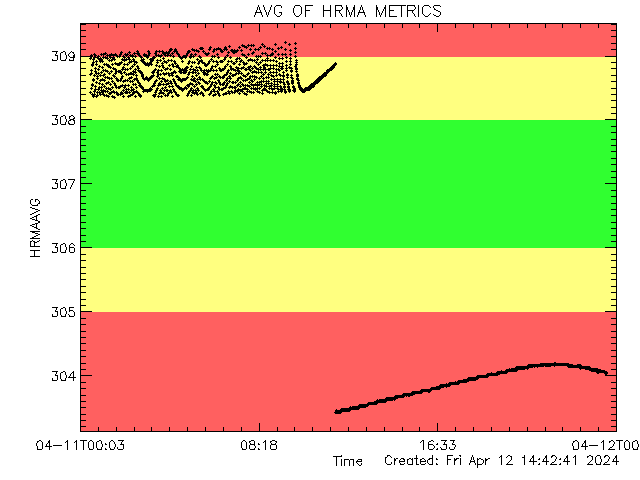

MTA Limit Trend Plot HRMAAVG https://cxc.cfa.harvard.edu/mta/MSID_Trends/Compgradkodak/Hrmaavg/hrmaavg_mid_static_short_plot.html
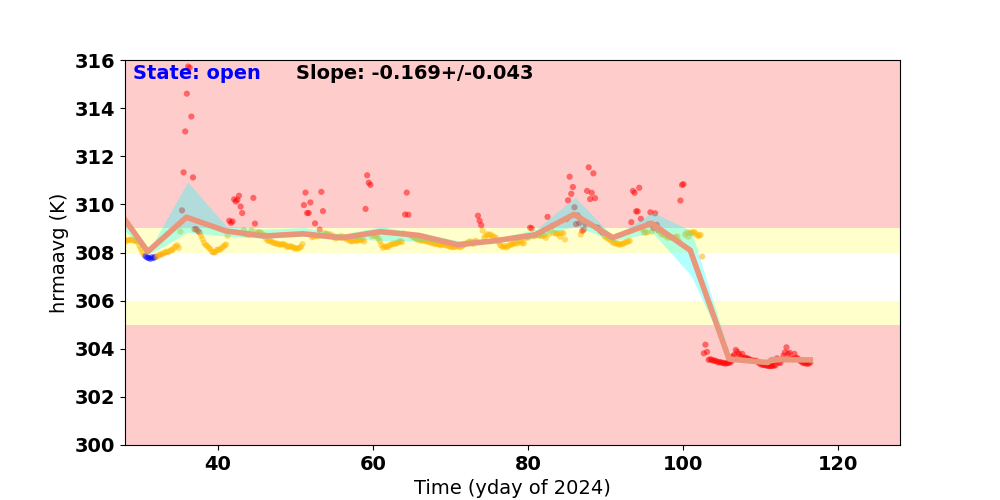

MTA Limit Trend Plot OHRTHR28 https://cxc.cfa.harvard.edu/mta/MSID_Trends/Hrmaheaters/Ohrthr28/ohrthr28_mid_static_short_plot.html
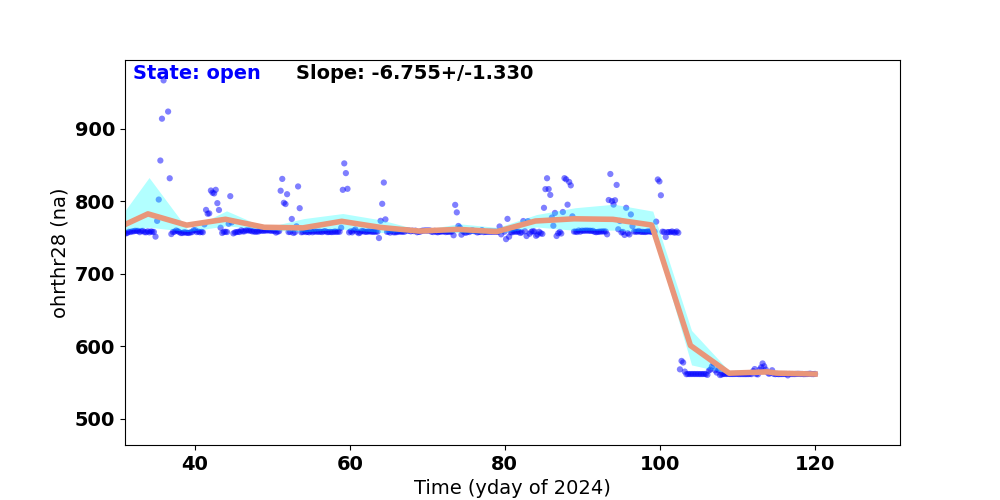

## TL;DR

The discontinuity was caused by MTA using the OHRTHR28 heater to calculate the average HRMA temperature. This heater contains invalid data and no longer reflects the actual temperature used for this thermistor. As such, when the calibration was altered to translate OHRTHR telemetry from the narrow to wide setting, calibration was not added to OHRTHR28. Instead, what occured was a change from a data fetch of invalid data ranging around 760K to invalid data ranging around 500K. This difference caused the MTA calculated HRMAAVG value to incorporate this discontinuity as well.

This issue was resolved in PR42 of the MTA repo.

https://github.com/chandra-mta/MTA/pull/42

In [1]:
import os
import sys
from cheta import fetch
import Ska.Matplotlib
import Chandra.Time
from Ska.tdb import msids
import numpy
import matplotlib.pyplot as plt

The following functions are used in the update_compgradkodak.py python script to calculate the hrmaavg value.

In [2]:
def fill_gaps(ttime, otime, data):
    """
    match the numbers of entries accroding to two time lists
    the data are repeated between two time stamps of the data to be filled
    input:  ttime   --- an array of time to be matched
            otime   --- an array of time of the data
                        len(ttime) > len(otime)
            data    --- an array of data
    output: adata   --- adjusted data
    """
#
#--- convert numpy array to list
#
    ttime = list(ttime)
    data  = list(data)
    otime = list(otime)

    tlen  = len(ttime)
    mlen  = len(otime)

    adata = []
    n     = 0
    chk   = 0
    for m in range(0, tlen):
        if ttime[m] > otime[n]:
            while ttime[m] > otime[n]:
                n += 1
                if n >= mlen:
                    diff = tlen - len(adata)
                    for nk in range(0, diff):
                        adata.append(data[n-1])
                    chk = 1
                    break
                else:
                    if ttime[m] == otime[n]:
                        adata.append(data[n])
                        break
        elif ttime[m] < otime[n]:
            adata.append(data[n])
        else:
            adata.append(data[n])
            n += 1
            if n >= mlen:
                diff = tlen - len(adata)
                for nk in range(0, diff):
                    adata.append(data[n-1])
                chk = 1
        if chk == 1:
            break
#
#--- put back into numpy array
#
    adata = numpy.array(adata)

    return adata

#-------------------------------------------------------------------------------------------
#-- take_sum: take average of the given data                                              --
#-------------------------------------------------------------------------------------------

def take_sum(olist, data, pos, achk=0):
    """
    take average of the given data
    input:  olist   --- a list of data ids
            data    --- a list of data
            pos     --- the position of the data to be used in data[*]
            achk    --- if 0, just retur the sum, if >0, take an average
    output: asum or avg --- asum (achk=0): sum of the values
                            avg  (achk>0): averaged of the values
    """
    asum = 0.0
    tot  = 0.0
    for k in olist:
        try:
            val = data[k][pos]
            if val > 0:
                asum += data[k][pos]
                tot  += 1.0
        except:
            pass

    if achk == 0:
        return asum

    else:
        try:
            avg = asum / tot
        except:
            avg = 'na'

        return avg

#-------------------------------------------------------------------------------------------
#-- compute_hrmaavg: compute hrma temp average                                            --
#-------------------------------------------------------------------------------------------

def compute_hrmaavg(ohrthr, pos):
    """
    compute hrma temp average
    input:  ohrthr  --- a list of ohrthr data lists
            pos     --- the position of the data in the ohrthr[*]
    output: hrmaavg --- hrma temp average
    """
    olist    = list(range(2,14)) + list(range(21,31)) + [33, 36, 37, 42] 
    olist    = olist + list(range(44,48)) + list(range(49,54)) + [55, 56]
    hrmaavg  = take_sum(olist, ohrthr, pos, achk=1)

    return hrmaavg
    

## Difference in MTA-computed HRMAAVG (cause of discontinuity)

First, we are using the path notes located in https://github.com/sot/cheta/pull/261/files#L462 to determine the exact time of the conversion to WIDE. MTA uses cheta (as Ska.engarchive.fetch) to pull MSID data for trending.

According to the wide conversion PR in cheta in Line 462, there was a transition at "2024:102:11:49:35" for a set of the OHRTHR heaters. Then there was a transition at "2024:102:11:52:19" for another set of the OHRTHR heaters plus the 4OAVHRMT msid, which is the OBC computed average. 

**NOTE:** When fetching the msid data in cheta, there is a built in patch which maps the results of an OHRTHR MSID fetch to their WIDE version. This allows for backwards compatability such that any OHRTHR or 4OAVHRMT fetch will map to the correct usage of the NARROW or WIDE version of the MSID before or after their respective transition time.

In [3]:
start = "2024:102:11:40:35"
stop = "2024:102:11:59:19"

There are two processes of interest for trending the average HRMA temperature. 

The first is the 4OAVHRMT MSID which is calculated by the OBC from a selection of the OHRTHR heaters. 

The second is the HRMAAVG value which is calculated by fetching the post-telemetered calculated values of the OHRTHR heaters and averaging a selection of these temperatures.

Selection of OHRTHR heaters used but OBC (sourced by Christian Anderson)

|||||||
|---|---|---|---|---|---|
|OHRTHR02|OHRTHR03|OHRTHR04|OHRTHR05|OHRTHR06|OHRTHR07|
|OHRTHR08|OHRTHR09|OHRTHR10|OHRTHR11|OHRTHR12|OHRTHR13|
|OHRTHR21|OHRTHR22|OHRTHR23|OHRTHR24|OHRTHR25|OHRTHR26|
|OHRTHR27|OHRTHR29|OHRTHR30|OHRTHR33|OHRTHR36|OHRTHR37|
|OHRTHR42|OHRTHR44|OHRTHR45|OHRTHR46|OHRTHR47|OHRTHR49|
|OHRTHR50|OHRTHR51|OHRTHR52|OHRTHR53|OHRTHR55|OHRTHR56|

In [4]:
OBC_sel = list(range(2,13+1)) + list(range(21,27+1)) + [29,30,33,36,37,42]
OBC_sel += list(range(44,47+1)) + list(range(49,53+1)) + [55,56]

MTA selection for the HRMAAVG calcualted value (sourced from MTA_limit_trends/Deposit/update_compgradkodak.py)

In [5]:
MTA_sel = list(range(2,14)) + list(range(21,31)) + [33, 36, 37, 42] 
MTA_sel += list(range(44,48)) + list(range(49,54)) + [55, 56]

In [6]:
set(MTA_sel).difference(set(OBC_sel))

{28}

Therefore on the MTA side, we include the OHRTHR28 incorrectly when calculating the average

In [7]:
msids.find("OHRTHR28")

[<MsidView msid="OHRTHR28" technical_name="INVALID: TELESCOPE THERMISTOR DATA: HRMA CH 27">]

This MSID is currently listed as invalid, not to mention that around the time of the WIDE conversion, it carried a significant discontinuity from values around 750 K dropping down to 500 under the new acorn calibration (already a significant contributor compared to other OHRTHR heaters typically around 300 K).

To mimic our MTA Trending page calculation, we take the following steps sourced from update_compgradkodak.py.

In [8]:
#We depend on the time scale used in fetching 4rt data first
empty  = [0]
#
#--- extract  4rt*** data
#
rt7  = []
for k  in range(0, 12):
    if k < 10:
        msid = '4rt70' + str(k) + 't'
    else:
        msid = '4rt7'  + str(k) + 't'

    try:
        out   = fetch.MSID(msid, start, stop)
        data  = out.vals
        ttime = out.times
        tlist = list(ttime)
        rt7.append(data)
    except:
        rt7.append(empty)
#
#--- extract 4rt575t separately
#
out    = fetch.MSID('4rt575t', start, stop)
rt575  = out.vals
#
#--- create empty array and initialize ohrthr and oobthr lists
#
tlen   = len(ttime)
empty  = numpy.zeros(tlen)

Then the ohrthr list of lists is initialized based on the results of that fetch.

In [9]:
ohrthr = [empty]
oobthr = [empty]

#
#--- fill them up
#
for k in range(1, 65):
    if k < 10:
        msid = 'ohrthr0' + str(k)
    else:
        msid = 'ohrthr'  + str(k)
    try:
        out   = fetch.MSID(msid, start, stop)
        data  = out.vals
        otime = out.times
#
#--- since 4rt arrays are 36 time dense, match the ohrthr and oobtrhr 
#--- by filling the gaps between
#
        adata = fill_gaps(ttime, otime, data)

        ohrthr.append(adata)
    except:
        ohrthr.append(empty)

Therefore, we get a list of data, indexed by the OHRTHR number, in which the zeroth index is flled with dummy zeroes. We then compute various temeprature averages using this data set.

In [10]:
#
#--- now compute each quantity for the given time period
#
hrmaavg         = []
#
#--- save time stamp separately for each data   
#
t_hrmaavg       = []

for k in range(0, tlen):
    out = compute_hrmaavg(ohrthr, k )
    if out != 'na':
        hrmaavg.append(out)
        t_hrmaavg.append(tlist[k])

Text(38.097222222222214, 0.5, 'Temperature (K)')

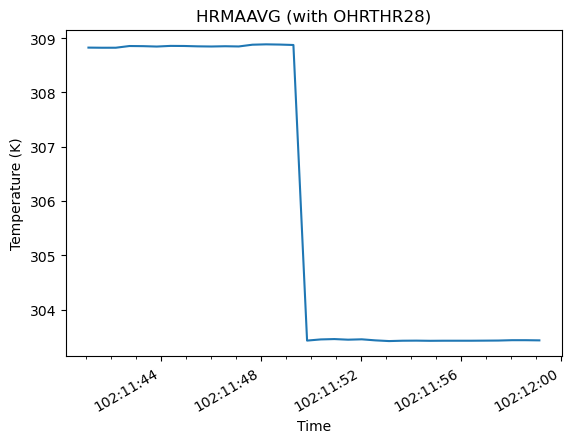

In [11]:
ticklocs, fig, ax = Ska.Matplotlib.plot_cxctime(t_hrmaavg, hrmaavg)
ax.set_title("HRMAAVG (with OHRTHR28)")
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

Because we incorrectly use the invalid OHRTHR28 msid which has a large discontinuity at this time point, our calculated average carried that discontinuity over as well. If we were to repeat the process used in the compute_hrmaavg function above, but use the OBC selection of msid, we obtain...

In [12]:
OBC_hrmaavg = []
OBC_t_hrmaavg = []
for k in range(0, tlen):
    out  = take_sum(OBC_sel, ohrthr, k, achk=1)
    if out != 'na':
        OBC_hrmaavg.append(out)
        OBC_t_hrmaavg.append(tlist[k])

Text(33.722222222222214, 0.5, 'Temperature (K)')

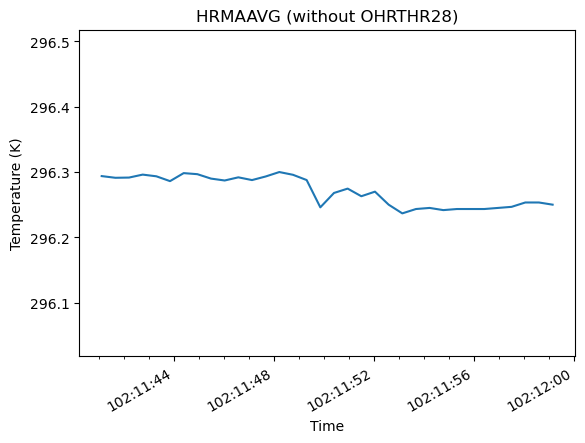

In [13]:
ticklocs, fig, ax = Ska.Matplotlib.plot_cxctime(OBC_t_hrmaavg, OBC_hrmaavg)
Ska.Matplotlib.set_min_axis_range(ax,0.5)
ax.set_title("HRMAAVG (without OHRTHR28)")
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

With the removal of OHRTHR28, the HRMAAVG temperature not only becomes continuous as expected.